In [1]:
'''
This Jupyter note books aims to do EDA and analyze base models performance 
Base model experiments : 
- KNN
- Logstic Regression
- Neural Network 
Authors: Jason Rudianto , Xin Chen
'''

'\nThis Jupyter note books aims to do EDA and analyze base models performance \nAuthors: Jason Rudianto , Xin Chen\n'

In [2]:
# standard
import pandas as pd
import numpy as np
import random
import os
from collections import Counter

# tf and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline


IMAGE_PATH = 'dataset/'

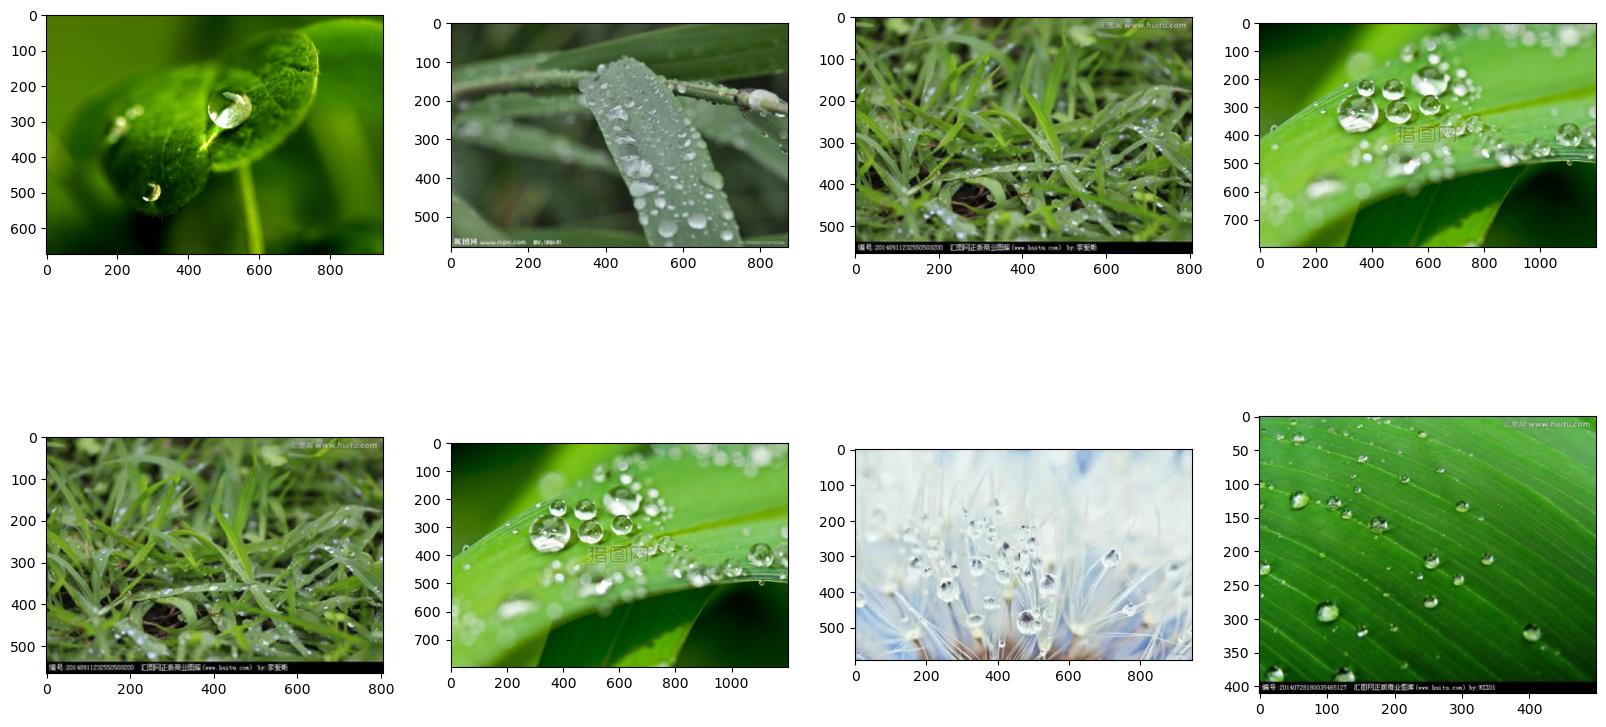

In [3]:
# read image
indx=0
images = [] 
y = []


# images are nested in subdirectories. The subdirectory an image is in represents 
idx = 0
for weather_subdir in os.listdir(IMAGE_PATH):
    weather_subdir_path = IMAGE_PATH + weather_subdir
    if (os.path.isdir(weather_subdir_path)):
        for img in os.listdir(weather_subdir_path):
            img_path = weather_subdir_path + '/' + img
            y.append(weather_subdir)
            img = load_img(img_path)
            images.append(img)
        

# print some sample images
nrows, ncols = 2,4 #print 8 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = i*nrows+j
        axs[i,j].imshow(images[indx])

In [4]:
# look at the various weather condiition and the number of samples we have for each weather type
print("Frequency by weather condition: " + str(Counter(y)))


Frequency by weather condition: Counter({'rime': 1160, 'fogsmog': 851, 'dew': 698, 'sandstorm': 692, 'glaze': 639, 'snow': 621, 'hail': 591, 'rain': 526, 'frost': 475, 'lightning': 377, 'rainbow': 232})


In [5]:
# note that the labels are still its class names rather than numerical. Transform `y`
class_to_numerical_label = {'lightning': 0,
         'sandstorm': 1,
         'glaze': 2,
         'rain': 3,
         'rime': 4,
         'frost': 5,
         'fogsmog': 6,
         'hail': 7,
         'dew': 8,
         'rainbow': 9,
         'snow': 10}
y_encoded = [class_to_numerical_label[weather] for weather in y]
print("Frequency by weather condition label: " + str(Counter(y_encoded)))
print("total number of imagies： ", len(y_encoded))

Frequency by weather condition label: Counter({4: 1160, 6: 851, 8: 698, 1: 692, 2: 639, 10: 621, 7: 591, 3: 526, 5: 475, 0: 377, 9: 232})
total number of imagies：  6862


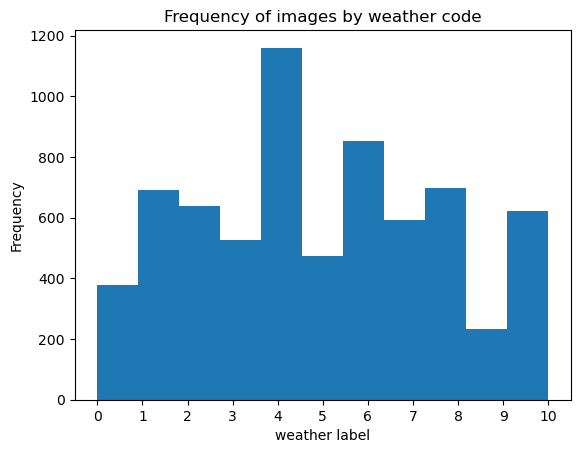

In [6]:
n_bins = 11
plt.hist(y_encoded, n_bins) 
plt.xticks(range(0, 11, 1))
plt.title("Frequency of images by weather code")
plt.ylabel("Frequency")
plt.xlabel("weather label")
plt.show()

In [7]:
def preprocess_data_part1(IMAGE_PATH, IMAGE_DIMENSION=(100,200), MAX_SAMPLE_SIZE_PER_CLASS = 200, random_seed = 1234):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    IMAGE_DIMENSION (int, int): image resolution to resize images to
    MAX_SAMPLE_SIZE_PER_CLASS (int): the maximum number of samples to take for any single class
    
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, IMAGE_DIMENSION[0], IMAGE_DIMENSION[1], 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    np.random.seed(random_seed)
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    for weather_subdir in os.listdir(IMAGE_PATH):
        weather_subdir_path = IMAGE_PATH + weather_subdir
        imgs_for_weather_class = []
        if not (os.path.isdir(weather_subdir_path)):
            continue
        for img in os.listdir(weather_subdir_path):
            img_path = weather_subdir_path + '/' + img
            # read image
            img = load_img(img_path, target_size = IMAGE_DIMENSION)
            # transform to img to array
            img = img_to_array(img)
            # append to the images for this class
            imgs_for_weather_class.append(img)

        # sample the image if the count is larger than provided max size
        if (len(imgs_for_weather_class) > MAX_SAMPLE_SIZE_PER_CLASS):
            imgs_for_weather_class = random.sample(imgs_for_weather_class, MAX_SAMPLE_SIZE_PER_CLASS)
        # add the images for this weather class to images_mini
        images_mini.extend(imgs_for_weather_class)
        weather_label = class_to_numerical_label[weather_subdir]
        y_mini.extend([weather_label for i in range(len(imgs_for_weather_class))])
            

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [8]:
# generate images and labels based on preprocess_data_part1() function
# TODO (SAVINAY) - feel free to alter the dataset 
images_mini, y_mini = preprocess_data_part1(IMAGE_PATH)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (2200, 100, 200, 3)
y_mini shape (2200,)


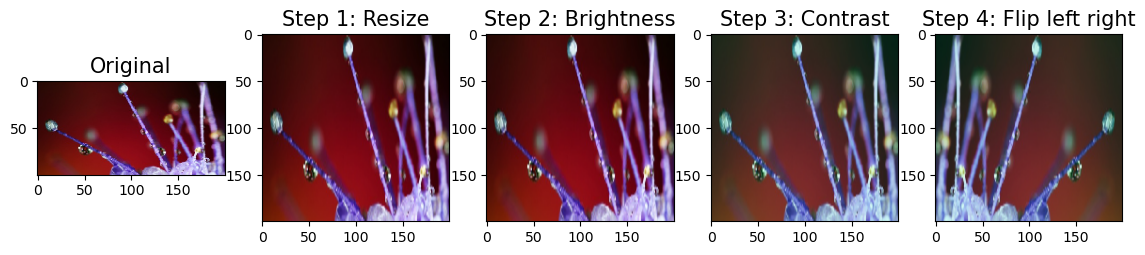

In [9]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(200, 200))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

In [10]:
IMAGE_SIZE = (200, 200)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2), image_size=IMAGE_SIZE):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=image_size)
    X_val = tf.image.resize(X_val, size=image_size)
    X_test = tf.image.resize(X_test, size=image_size)
    
    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (2640, 200, 200, 3)
y_train shape (2640,)
X_val shape (440, 200, 200, 3)
y_val shape (440,)
X_test shape (440, 200, 200, 3)
y_test shape (440,)


In [12]:
#baseline models : KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Flatten the images for kNN
X_train_flattened = X_train.numpy().reshape(X_train.shape[0], -1)
X_val_flattened = X_val.numpy().reshape(X_val.shape[0], -1)
X_test_flattened = X_test.numpy().reshape(X_test.shape[0], -1)


# Initialize the kNN classifier
k = 11  # Number of neighbors to consider
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the kNN classifier
knn_classifier.fit(X_train_flattened, y_train)

# Predict on the validation set
y_pred_val = knn_classifier.predict(X_val_flattened)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation accuracy:", val_accuracy)

# Predict on the test set
y_pred_test = knn_classifier.predict(X_test_flattened)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test accuracy:", test_accuracy)

Validation accuracy: 0.3
Test accuracy: 0.2863636363636364


dict_keys(['lightning', 'sandstorm', 'glaze', 'rain', 'rime', 'frost', 'fogsmog', 'hail', 'dew', 'rainbow', 'snow'])


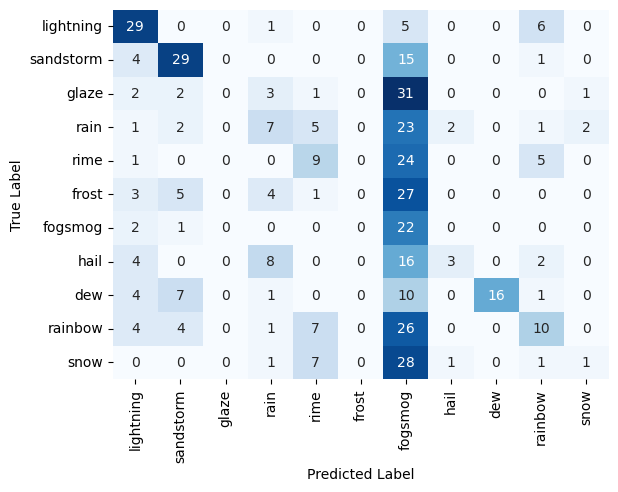

precision across classes:  [0.53703704 0.58              nan 0.26923077 0.3               nan
 0.0969163  0.5        1.         0.37037037 0.25      ]


C:\Users\gigif\AppData\Local\Temp\ipykernel_9372\265605660.py:18: RuntimeWarning: invalid value encountered in divide
  precision = TP/TPandFP


In [13]:
# Create a confusion matrix 
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred_test)


# Use a heatmap plot to display it.
class_names = class_to_numerical_label.keys()
print(class_names)
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()


TPandFP = np.array(confusion_matrix).sum(axis = 0)
TP = np.diagonal(np.array(confusion_matrix))
precision = TP/TPandFP
print('precision across classes: ', precision)

Training...


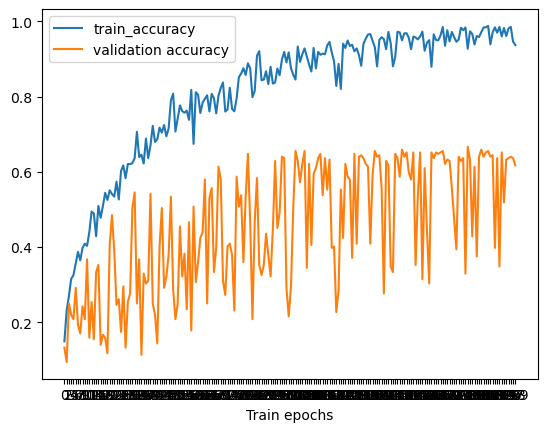

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 120000)            0         
                                                                 
 dense (Dense)               (None, 11)                1320011   
                                                                 
Total params: 1,320,011
Trainable params: 1,320,011
Non-trainable params: 0
_________________________________________________________________
None
Test Accuracy: 0.4250


In [14]:
#baseline models : logistic regression
def build_logistic_model(n_classes,
                optimizer='SGD',
                learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(
      units=n_classes,             # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation="softmax"         # apply the sigmoid function!
  ))


  model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), #(from_logits=True) , 
                optimizer= optimizer, 
                metrics=['accuracy'])
  return model

def train_model( optimizer='SGD',
                 learning_rate=0.01,
                 num_epochs= 5):

  # Build the model.
  model = build_logistic_model(n_classes=11,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Train the model.
  print('Training...')
  history = model.fit(
    x=X_train,
    y=y_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(val_accuracy, label='validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()
 
  return model 


logistic_model = train_model(optimizer='SGD',
                 learning_rate=0.01,
                 num_epochs=200)


def get_test_accuracy(model):
  test_accuracy = model.evaluate(x=X_test, y= y_test, verbose=0,
                                 return_dict=True)['accuracy']
    
  print(model.summary())
  return test_accuracy

f = get_test_accuracy(logistic_model)
print('Test Accuracy: %1.4f' %f)


Training...


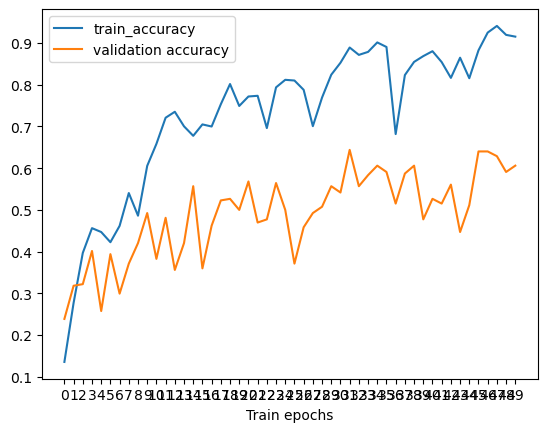

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 120000)            0         
                                                                 
 dense (Dense)               (None, 256)               30720256  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 11)                1419      
                                                                 
Total params: 30,754,571
Trainable params: 30,754,571
Non-trainable params: 0
_________________________________________________________________
None
Test Accuracy: 0.4409


In [15]:
#baseline models : neural network
def build_nn_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
  """Build a multi-class neural network using Keras.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten())
  for n in hidden_layer_sizes:
        model.add(keras.layers.Dense(units = n, activation= activation))
  model.add(keras.layers.Dense(units = n_classes, activation= 'softmax'))  

  model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), #(from_logits=True) , 
                optimizer= optimizer, 
                metrics=['accuracy'])
  return model

def train_model(hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5):

  # Build the model.
  model = build_nn_model(n_classes=11,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Train the model.
  print('Training...')
  history = model.fit(
    x=X_train,
    y=y_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(val_accuracy, label='validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()
 
  return model 

nn_model = train_model(hidden_layer_sizes= [256, 128],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=50)


def get_test_accuracy(model):
  test_accuracy = model.evaluate(x=X_test, y= y_test, verbose=0,
                                 return_dict=True)['accuracy']
    
  print(model.summary())
  return test_accuracy

f = get_test_accuracy(nn_model)
print('Test Accuracy: %1.4f' %f)



In [16]:
tf.random.set_seed(1234)
np.random.seed(1234)
shuffle = np.random.permutation(np.arange(images_mini.shape[0]))
print(shuffle)
print(y_test)
print(X_train[0].shape)

[1835 1821 1934 ...  664 1318  723]
[ 8  8  7  9 10  5  3  3  3  2  0  9  4  7  1  6  0  9  0  0  4  9  1  4
  7 10  1  5  4  0  8  5  3  8  8  6  3  2  3  5  2  8  8  3  6 10  7  5
  4 10  1 10  3 10  5  8 10  2 10  8  6  4  5  0  3  0 10 10 10  5  2  5
  9  1  6  1  4  8  9  9  8  4  8  1  4  4  9  9  7  8  0  1  3 10  3  2
  9  9  6  0  7  1  3 10  0  9  1  5 10  2  0  5  8 10  0  0  5  0  1  1
  3  7  3  3  1  1  2  0  4  1  5  2  8  9  0  0  9  0  1  6  1  4  2  1
  9  4 10  1 10  5  7  9  7 10 10  4  5  8  2  2  1  9  2  0  4  1  4  0
  6  3  9  7  9  2  9  5  3  1  9  7  8  1  8  8  1  5  6  7  1  9  9  5
  2  2  4  4  7  3  5  9  8  5  0  7  7  9  2  9  5  7  0  5  5  2  4  1
  3  3  9  8  5  9  9  1  9  7  9  9  1  9  7  9  7  9  0  2  1  3 10  5
  4  8  3  7  3  2  7  0  2  6  0  4 10  0  9  0  1  4  1  9  4  7  2 10
  3  3 10  4  6  9  4  5  7  4  9 10  8  8  5  9 10  4  9  2  8  0  0  3
  2  2  1  8  5  2  2  9  3  1  6  3  1  7  7  3  4  7  4  4  6  5  9  2
  5 10  4  5  0

14/14 [==============================] - 0s 7ms/step
dict_keys(['lightning', 'sandstorm', 'glaze', 'rain', 'rime', 'frost', 'fogsmog', 'hail', 'dew', 'rainbow', 'snow'])


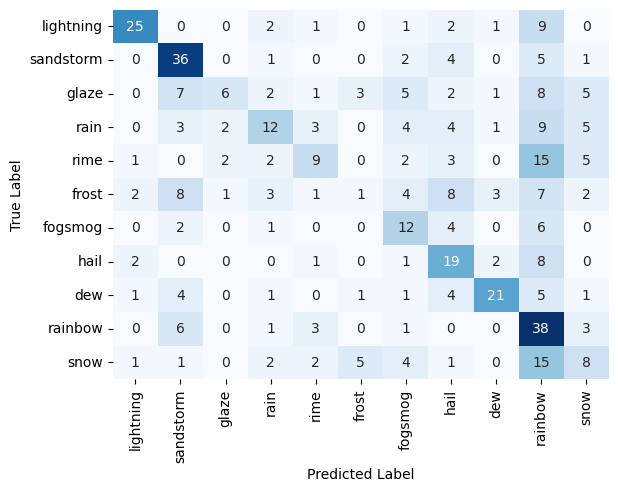

precision across classes:  [0.78125    0.53731343 0.54545455 0.44444444 0.42857143 0.1
 0.32432432 0.37254902 0.72413793 0.304      0.26666667]


In [17]:
def get_pred_class(model):
  test_predictions = np.argmax(model.predict(X_test), axis=-1)
  return test_predictions

test_predictions = get_pred_class(logistic_model) #

# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, test_predictions)


# Use a heatmap plot to display it.
class_names = class_to_numerical_label.keys()
print(class_names)
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()


TPandFP = np.array(confusion_matrix).sum(axis = 0)
TP = np.diagonal(np.array(confusion_matrix))
precision = TP/TPandFP
print('precision across classes: ', precision)


In [18]:
#check any pattern in average color digits 
avg_color = np.empty((11, 3))
for k in class_to_numerical_label.keys():
    i = class_to_numerical_label[k]
    _imgs = X_train[y_train == i]
    m = tf.reduce_mean(_imgs, axis=(0, 1, 2))
    avg_color[i,:] = m
    #m = tf.reduce_mean(m, axis = 0)
    #s = tf.math.reduce_std(_imgs_r)
    #print(m.shape)
    #print(f"image type:  {k}: input mean: {m.numpy()} " )

print(pd.DataFrame(index = class_to_numerical_label.keys(), data = avg_color, columns = ['R', 'G', 'B']))

                  R         G         B
lightning  0.464953  0.460155  0.597675
sandstorm  0.781127  0.668439  0.538163
glaze      0.665267  0.655716  0.636606
rain       0.634858  0.638706  0.623042
rime       0.710444  0.758390  0.843787
frost      0.618656  0.615587  0.583196
fogsmog    0.727513  0.728931  0.725597
hail       0.663625  0.650639  0.604898
dew        0.522090  0.612970  0.428935
rainbow    0.661051  0.703029  0.744840
snow       0.760338  0.766280  0.781114
